# Data Modeling with Astropy

__Author: Kaustubh Vaghmare__

"modeling" is a library in Python designed to give you

- Access to commonly used models.
- As well as fit them to various data.

Let's see how to use this module.

First off, we will use the models prebuilt into this module to generate some data.

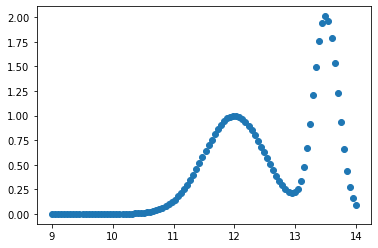

In [2]:
from astropy.modeling import models
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(9, 14, 100)
gauss_example1 = models.Gaussian1D(amplitude=1.0, mean=12, stddev=0.5)
gauss_example2 = models.Gaussian1D(amplitude=2.0, mean=13.5, stddev=0.2)
gauss_total = gauss_example1 + gauss_example2
y = gauss_total(x)

plt.scatter(x,y)

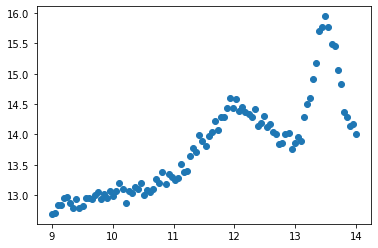

In [3]:
import numpy.random as nr

y_noise = nr.normal(0, 0.1, len(x))
y_obs = 12 + 0.01*x**2 + y + y_noise
plt.scatter(x, y_obs)

We saw how trivial it is to use a model and actually evaluate it over a range. But a more useful thing we need to do with models is to fit some data. Now, pretend that x and y_obs are two arrays that contain our observed data. We can start by plotting the same.

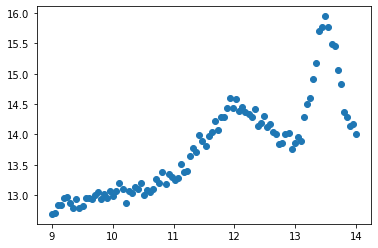

In [4]:
plt.scatter(x, y_obs)

Once we have a plot, our next step is to choose a model. What model shall fit the data well? Let us assume that these are spectral features with some known wavelengths. So, we may assume that each feature is a Gaussian. To minimize number if independent parameters, we may also consider that the difference in the wavelengths is a constant. Such a constraint obviously comes from our prior knowledge of the physical system that generated the spectrum.

Next, these emission features clearly are not on their own - they are stop a continuum. Assuming that the continuum is not varying at a fast rate wrt wavelengths (X-axis), we can further assume that a quadratic polynomial suffices in accounting for this.

So, our model is a second order polynomial plus two Gaussians, with different means but separated by a known amount.


In [13]:
# So, let us construct our model.
model = models.Gaussian1D(amplitude=1.0, mean=12.1, stddev=0.5) +\
        models.Gaussian1D(amplitude=1.0, mean=13.6, stddev=0.4) +\
        models.Polynomial1D(degree=2)

In [14]:
print(model.param_names)

('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1', 'c0_2', 'c1_2', 'c2_2')


In [15]:
# Our model is not complete. We must supply our constraint.
def constraint_mean(model):
    mean_0 = model.mean_1 - 1.5
    return mean_0

model.mean_0.tied = constraint_mean

The model is ready. We have the data. What we finally need is a fitting algorithm. Let us choose the Marquardt Levenberg method.

In [18]:
from astropy.modeling import fitting
fitter = fitting.LevMarLSQFitter()

model_fit = fitter(model, x, y_obs)

In [19]:
model_fit.parameters

array([9.75761883e-01, 1.19947500e+01, 4.73240100e-01, 1.99994340e+00,
       1.34947500e+01, 1.88241905e-01, 1.16996934e+01, 4.57407605e-02,
       8.49344516e-03])

In [20]:
model_fit.param_names

('amplitude_0',
 'mean_0',
 'stddev_0',
 'amplitude_1',
 'mean_1',
 'stddev_1',
 'c0_2',
 'c1_2',
 'c2_2')

In [21]:
dict(zip(model_fit.param_names, model_fit.parameters))

{'amplitude_0': 0.9757618832637589,
 'mean_0': 11.994749999368633,
 'stddev_0': 0.47324010021733376,
 'amplitude_1': 1.9999434021287998,
 'mean_1': 13.494749999368633,
 'stddev_1': 0.1882419046695019,
 'c0_2': 11.699693426027737,
 'c1_2': 0.045740760547267445,
 'c2_2': 0.008493445155085239}

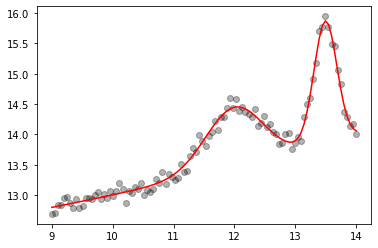

In [22]:
plt.scatter(x, y_obs, color='black', alpha=0.3)
plt.plot(x, model_fit(x), color='red')